# SDF Model Example 2: Building From Scratch

 In this jupyter notebook, we're going to showcase how to fit SDF models from scratch.

Data and datasets are found in the `Data/` subfolder. Helper scripts and the `SDFModel` class are available in the `Scripts/` subfolder.

In [1]:
# enables direct importing of .py files
import sys
sys.path.insert(0, "Scripts/")

#### Version Control

We output the version of all the main software to run this example. Optional software is included, which can be removed from the set if needed.

In [2]:
import version
version.control({"numpy","scipy","matplotlib","pandas","sklearn",
                 "joblib","tqdm","jupyter","xgboost","seaborn","xlrd","pip"})

python: 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:10:34) [MSC v.1916 64 bit (AMD64)]
pip: 21.1.2
pandas: 1.2.3
jupyter has no __version__ attribute.
xgboost: 1.4.0
joblib: 1.0.1
tqdm: 4.59.0
numpy: 1.19.2
xlrd: 2.0.1
matplotlib: 3.3.4
seaborn: 0.11.1
scipy: 1.6.2
sklearn: 0.24.1


#### Other imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Loading in the preprocessed SDFs

Here following from the thesis, we provide a **raw** and **preprocessed** versions of the sequence-derived feature set.

- Raw: base frequencies are counts, absolute minimialistic processing; requires heavy work to be used in machine learning
- Preprocessed: scaling by gene length, applied PCA|MCA pipeline (see thesis and paper), and other steps. Can be fed directly into a machine learning regressor. **NOT associated with any expression (mRNA, protein) data**.

Let's view the preprocessed data, which we provide in a .csv file. For convenience and additional functionality, we use a custom `PandaWrapper` class which simply wraps around `pandas.DataFrame` and provides nice selection functions.

In [4]:
from pandawrapper import PandaWrapper, read

Here $n$ is the number of rows/samples and $p$ is the number of features/dimensions. This nomenclature is common in machine learning parlance. We also see the dataset consumes a mere 16MB in memory. The preprocessed set covers 15K samples.

The file we load in here is sequence-derived features that are grouped and then processed via PCA (hence 's' for stratified). 'dg' refers to *data group*: i.e are you a mononucleotide frequency, biophysical property etc. Amino acid meta features, since they remain discrete from prior preprocessing, undergo MCA (multiple correspondence analysis) which is a PCA equivalent for discrete matrices. 

We also provide a `read` function which can read in multiple files at once and process them. Alternatively you could just call `pd.read_csv` and then call `PandaWrapper` on the dataframe object.

In [5]:
preproc_sdf = read("Data/sPCA_dg_mca.csv")
preproc_sdf

PandaWrapper(sPCA_dg_mca(n=15269, p=137, mem=16.735MB))

However the true number is slightly lower due to a very small amount of overlap:

In [6]:
print(f"unique ensembl ids: {preproc_sdf.ensembl_id.unique().shape}")
print(f"unique uniprot ids: {preproc_sdf.uniprot_id.unique().shape}")

unique ensembl ids: (15063,)
unique uniprot ids: (15005,)


In [7]:
preproc_sdf.head(3)

,ensembl_id,uniprot_id,PC_mononuc_freq1,PC_mononuc_freq2,PC_mononuc_freq3,PC_mononuc_freq4,PC_mononuc_freq5,PC_mononuc_freq6,PC_mononuc_freq7,PC_mononuc_freq8,...,MCA15,MCA16,MCA17,MCA18,MCA19,MCA20,MCA21,MCA22,MCA23,MCA24
0,ENSG00000121410,P04217,4.715001,0.923349,-0.890998,0.494925,0.182820,0.366784,-0.306843,1.349806,...,0.094260,-0.004007,-0.059522,-0.037662,-0.055998,0.012324,0.076928,0.038517,-0.091606,-0.003670
1,ENSG00000148584,Q9NQ94,-3.837506,2.297875,-0.235609,0.215278,0.078727,0.713184,-0.547929,-0.174856,...,-0.015422,-0.110948,0.047045,0.064683,-0.081390,-0.081165,0.029678,-0.013192,0.017198,0.019519
2,ENSG00000175899,P01023,-1.822412,1.995094,1.345473,-0.638996,-0.528429,-0.272420,0.729907,-0.270425,...,0.048603,-0.017250,-0.039310,-0.042993,-0.002450,0.019993,0.076100,0.053227,0.034000,-0.112656


## Loading in expression data

Now we have our SDFs, it would be handy to have some expression data! For this example we have provided the mRNA and protein data provided in the Supplementary Material of Vogel et al. 2010 *Sequence signatures and mRNA concentration can explain two-thirds of protein abundance variation in a human cell line*. This dataset has also been used in our thesis. This is part of the human Daoy medulloblastoma cell line.

Inspecting the file indicates that the header is not at the top, so this must be specified.

In [8]:
vogel = read("Data/vogel_expression.xls", header=9)
vogel

PandaWrapper(vogel_expression(n=1051, p=11, mem=0.093MB))

You may notice the annoyingly verbose nature of the column names. Please fix this in the future biologists. The expression data is not $log_2$-normalized, so we will adjust for that also.

So what's going on here?

1. We use *regex* (REGular EXpressions) to find all column names that contain 'Expression' (only 2). 
2. We use `transform`: i.e pass a function that modifies every element and returns a Series of the same size.
3. We pass this `np.log2`, the function to compute a log-2 transformation.
4. We pass the returned result into `join()`: an operation to append on two column-ed results, specifying that the RHS should add the string suffix '_log2' to all it's column names.
5. We use the custom `call` function to ensure the result is re-wrapped as a `PandaWrapper` rather than `pandas.DataFrame`

In [9]:
vogel = vogel.call("join", vogel['Expression'].transform(np.log2), rsuffix="_log2")

In [10]:
vogel.head()

,HCD,Population,EnsemblGeneID,EnsemblTranscriptID,EnsemblProteinID,Protein Expression levels (molecules/cell),mRNA Expression Levels (arbitrary units),5UTR Sequence,Coding Sequence,3UTR Sequence,Amino Acid Sequence,Protein Expression levels (molecules/cell)_log2,mRNA Expression Levels (arbitrary units)_log2
0,HCD,P2,ENSG00000000971,ENST00000367429,ENSP00000356399,150.6036,2101.852653,ccttttgcagcaagttctttcctgcactaatcacaattcttggaag...,atgagacttctagcaaagattatttgccttatgttatgggctattt...,aatcaatcataaagtgcacacctttattcagaactttagtattaaa...,MRLLAKIICLMLWAICVAEDCNELPPRRNTEILTGSWSDQTYPEGT...,7.234612,11.037446
1,NaN,P2,ENSG00000002745,ENST00000361301,ENSP00000355065,110.5769,54.518717,agcctgcaaaaaccacagagggcaaagccagaaagatggaaaggcaccc,atgcagctcaccacttgcctcagggagaccctcttcacaggggctt...,ccactccatccagccttgggcaagatgcctcagcaatatacaatgg...,MQLTTCLRETLFTGASQKTSLWWLGIASFGVPEKLGCANLPLNSRQ...,6.788906,5.768680
2,NaN,P2,ENSG00000002746,ENST00000395891,ENSP00000379228,155.6035,93.004881,ggggatgcaagcgggaggataaagcgatgaagtgtgctgcgttacc...,atgctgctgcacctgtgtagtgtgaagaatctgtaccagaacaggt...,ggacatggaacctcgcctgacattttcctggccagtgacatcaccc...,MLLHLCSVKNLYQNRFLGLAAMASPSRNSQSRRRCKEPLRYSYNPD...,7.281731,6.539235
3,HCD,P3,ENSG00000004455,ENST00000354858,ENSP00000346921,64600.7637,3493.554230,ggcgtgcgaactggtggcagtgagagacttcggcggac,atggctcccagcgtgccagcggcagaacccgagtatcctaaaggca...,tgttgggtccaagaaggaatttctttccatccctgtgaggcaatgg...,MAPSVPAAEPEYPKGIRAVLLGPPGAGKGTQAPRLAENFCVCHLAT...,15.979264,11.770480
4,NaN,P3,ENSG00000004455,ENST00000373449,ENSP00000362548,64600.7637,1073.776953,gacctgggaagcactggacctgtgaggcgtgcgaactggtggcagt...,atggctcccagcgtgccagcggcagaacccgagtatcctaaaggca...,tatcagaaggccaggcgagactgcaacactgctcatcaccccgcgg...,MAPSVPAAEPEYPKGIRAVLLGPPGAGKGTQAPRLAENFCVCHLAT...,15.979264,10.068479


### Plotting the data

Here for sanity we will check the mRNA/protein relationship as a scatterplot. Note that we use the `&` selection with regex terms to find the intersection between the sets (i.e all columns containing mRNA AND log2 as a string), to select the one with the log2 transformation. This is because I hate writing long column names.

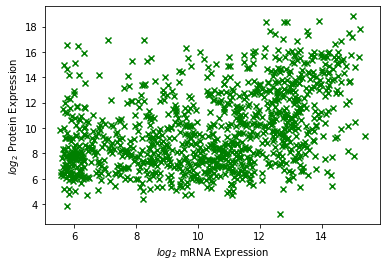

In [11]:
plt.scatter(vogel['mRNA & log2'], vogel['Protein & log2'], marker='x', color='green')
plt.xlabel(r"$log_2$ mRNA Expression")
plt.ylabel(r"$log_2$ Protein Expression")
plt.show()

## Integrating SDF and Expression

Merging the datasets is required if we are to map sequence information with mRNA/protein expression. This is normally a tricky business with finding the best unique label to integrate with, but you are in luck, as we provide a function that automatically finds the best index pairs and merges them for you!

Say hello to `merge_auto`, which takes the following arguments:

1. `dfs`: A list of DataFrames: the dataset(s) to merge, in chain-wise fashion from left to right
2. `how`: Whether to use inner, outer or left merge
3. `copy`: whether to copy the dataframes at each iteration
4. `handle_duplicates`: whether to drop duplicates at each chain step (all), no duplicate removed or only at the end.
5. `verbose`: error printing int

In [12]:
from merge_auto import merge_auto

This shows use that the *ensembl_id* label was used from SDF set and *ensembl_gene_id* was used from Vogel ($n=1000$), to merge, leaving $n=713$ remaining as some labels weren't identified. Note that this allows more than 2 datasets to merge, so if you want to try and keep as many labels as possible, integrating a HGNC-based consensus label set as a union operation may help to preserve higher $n$.

Finally, we re-wrap our PandaWrapper class to have a nicer output in the html format, and to retain our regex-power.

For details look at the `merge_auto` function.

In [13]:
intgr = PandaWrapper.wrap(
        merge_auto([preproc_sdf, vogel], verbose=3),
    name="sdf_expr")

Merging sPCA_dg_mca[15269,137] (`ensembl_id`) | vogel_expression[1051,13] (`EnsemblGeneID`) -> 713/0.68 on columns


## Final preprocessing steps

The only thing remaining now before fitting a model to this is removing unnecessary excess columns, dropping missing values and duplicates.

To do this, we firstly find all the columns we'd like to remove using regex operations (~ refers to the NOT operator). We then drop NAs and then finally drop our droppable columns.

In [14]:
droppables = PandaWrapper._sorted_union(vogel.view("~Expression|ID"), preproc_sdf.view("id | ID"))

In [15]:
preprocessed = (intgr.drop_duplicates(subset="ensembl_id")
                .dropna(subset=['Protein Expression levels (molecules/cell)_log2'])
                .drop(droppables, axis=1))

### Splitting full dataset into $\bf X$ and $y$

We'll use a similar column selection to get $\bf X$ and $\bf y$ datasets ready to build a simple fast ML model for demonstration. This involves splitting the data into input and target sets prior to using train-test-split and other methodologies.

- $\bf X$: Our sequence-derived information, as preprocessed
- $\bf y$: $\log_2$ protein abundance from the Daoy cell line

In [16]:
X = preprocessed[preproc_sdf.view("~id")]
y = preprocessed[vogel.view("log2 & Protein")].squeeze()

In [39]:
print(X.shape, y.shape)

(713, 135) (713,)


## Model selection via cross-validation

Here we will fit some models and ensure robustness via cross-validation.

Import some scikit-learn modules.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RepeatedKFold, cross_val_predict

Now perform 5-fold cross validation with an Ordinary Least Squares model. Note that sometimes cross-validation can be unreliable particularly if the **i.i.d** assumption is weak on the dataset (certain genes may be much better used to predict other genes for instance), so we use bootstrapped samples with 10 repeats to get a distribution of scores.

In [18]:
scores1 = cross_val_score(LinearRegression(), X, y, cv=RepeatedKFold(n_splits=5, n_repeats=10))
scores1.mean()

0.38411063047682753

#### Custom metrics

By default, regressors in scikit-learn use $R^2$ as the scoring metric. We can use mean-squared error or root-mean-squared-error as an alternative. We can also define a custom metric if we want to prevent $p$ from biasing $R^2$.

Using an adjusted $R^2$ metric like so:

In [109]:
from sklearn.metrics import r2_score, make_scorer
from functools import partial

In [105]:
def adjusted_r2(y_true, y_pred, n, p):
    """where n is the number of samples, p is the number of independent regressors (i.e number of variables)"""
    r2 = r2_score(y_true, y_pred)
    return 1.-(((1.-r2)*(n-1))/(n-p-1.))

Now we can use this function as a custom scorer. This is a little bit 'hacky' as technically `sklearn` only accepts functions that have `y_true` and `y_pred` as arguments. So we can use the `functools.partial` function to *wrap* the $n$ and $p$ arguments which are fixed for every iteration as determined by the dimensionality of $\bf X$.

In [113]:
my_r2 = partial(adjusted_r2, n=X.shape[0], p=X.shape[1])
# because make_scorer wants the function to have a name, we cheese it by setting the underlying attribute.
my_r2.__name__ = "adjusted_r2"

Hacks aside, now we re-run the cross-validation, with a new scoring function.

In [114]:
cross_val_score(LinearRegression(), X, y, cv=RepeatedKFold(n_splits=5, n_repeats=10), scoring=make_scorer(my_r2))

array([0.37193831, 0.20791436, 0.20359763, 0.2995551 , 0.24476313,
       0.16505784, 0.38173485, 0.28671935, 0.0310692 , 0.27066877,
       0.27771069, 0.17161738, 0.22086264, 0.24317672, 0.34542926,
       0.01401739, 0.36446322, 0.3442708 , 0.19119252, 0.32816241,
       0.18338465, 0.07961727, 0.29786323, 0.36412441, 0.24448793,
       0.1983554 , 0.31821385, 0.26402619, 0.34133621, 0.26728592,
       0.32456455, 0.35173129, 0.08312647, 0.34819148, 0.09777643,
       0.1677034 , 0.29436099, 0.28491729, 0.25330665, 0.07482236,
       0.06260473, 0.35063711, 0.23685246, 0.36471904, 0.23684158,
       0.2159368 , 0.35619149, 0.2718726 , 0.39398039, 0.10272764])

#### Distribution of scores

Verifying by distribution, both as histogram and kde estimate:

In [19]:
from scipy import stats

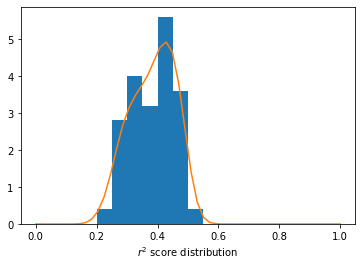

In [85]:
kde = stats.kde.gaussian_kde(scores1)
x_points = np.linspace(0, 1, 50)

plt.hist(scores1, bins=np.arange(0, 1, .05),
         density=True, histtype="stepfilled")
plt.plot(x_points, kde(x_points))
plt.xlabel(r"$r^2$ score distribution")
plt.show()

## Re-fitting models for prediction and coefficients

Now that we can see the models fitted are stable, we will re-fit a model and then look at the coefficients generated, and could use this model to potentially predict new proteins (although not that reliably given this dataset).

In [21]:
model1 = LinearRegression()
model1.fit(X, y)

LinearRegression()

#### Looking at feature coefficients...

Which are the greatest and lowest coefficients?

In [22]:
pd.Series(model1.coef_, index=X.columns).sort_values()

MCA17              -4.051566
PC_biophysical1    -2.894988
MCA18              -2.568343
MCA12              -2.553949
MCA23              -2.076042
                      ...   
PC_mononuc_freq2    1.381323
PC_mononuc_freq6    1.730381
PC_entropy2         1.863330
PC_aa_freq2         2.193870
PC_biophysical4     2.684593
Length: 135, dtype: float64

#### Predictions

Here we will take some of the rows which were dropped in the merging process, and generate estimated $log_2$ protein abundances for these values.

We take the full SDF set and the integrated label set and take the set difference.

In [31]:
non_integrated_labels = set(preproc_sdf['ensembl_id'].unique()) - set(intgr['ensembl_id'].unique())

Now we select all that contain the non-integrated labels, and use them to generate a large test set to make predictions from.

In [46]:
X_test = (preproc_sdf[preproc_sdf['ensembl_id'].isin(non_integrated_labels)]
          .call("drop_duplicates", subset=['ensembl_id'])
          .call("dropna")
          ['~id$'])

In [55]:
X_test

PandaWrapper(sPCA_dg_mca(n=14350, p=135, mem=15.613MB))

Generate predictions.

In [54]:
y_test = model1.predict(X_test)

## Fitting models including mRNA abundance

Now we will repeat but include the mRNA abundance as a feature to improve model accuracy.

In [79]:
X2 = preprocessed[preproc_sdf.view("~id").union(vogel.view("mRNA & log2"))]

Now for re-scoring.

In [80]:
scores2 = cross_val_score(LinearRegression(), X2, y, cv=RepeatedKFold(n_splits=5, n_repeats=10))
scores2.mean()

0.39783374114099984

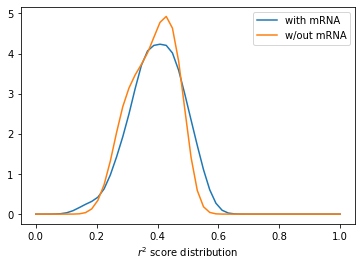

In [87]:
kde2 = stats.kde.gaussian_kde(scores2)
x_points = np.linspace(0, 1, 50)

plt.plot(x_points, kde2(x_points), label="with mRNA")
plt.plot(x_points, kde(x_points), label="w/out mRNA")
plt.xlabel(r"$r^2$ score distribution")
plt.legend()
plt.show()

We'll try using a Ridge $\ell_2$-regularizer term to reduce the impact of unessential SDFs, even though the coefficients seem reasonably well behaved.

In [88]:
from sklearn.linear_model import RidgeCV

In [93]:
model2 = RidgeCV(alphas=np.logspace(-4, -.5, 30), cv=RepeatedKFold(n_splits=5, n_repeats=10))
model2.fit(X2, y)

RidgeCV(alphas=array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01]),
        cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None))

In [100]:
model2.best_score_

0.4196036811817225

Best alpha out of the samples provided.

In [101]:
model2.alpha_

0.31622776601683794

This is the end of this notebook. In the next one, we'll look at some pre-trained models and how to use them.